In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "/kaggle/input/output-cleaned"
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-3
IMG_SIZE = 128


In [4]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [5]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_tf)
class_names = full_dataset.classes
num_classes = len(class_names)

targets = np.array(full_dataset.targets)


In [6]:
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_val_idx, test_idx = next(sss1.split(np.zeros(len(targets)), targets))

train_val_targets = targets[train_val_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
train_idx, val_idx = next(sss2.split(np.zeros(len(train_val_targets)), train_val_targets))

train_idx = train_val_idx[train_idx]
val_idx   = train_val_idx[val_idx]


In [7]:
train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)
test_ds  = Subset(datasets.ImageFolder(DATA_DIR, transform=test_tf), test_idx)

print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))


Train: 989
Val: 142
Test: 283


In [8]:
train_labels = [targets[i] for i in train_idx]
counts = Counter(train_labels)

weights = []
for i in range(num_classes):
    if counts[i] == 0:
        weights.append(0.0)
    else:
        weights.append(1.0 / counts[i])

class_weights = torch.tensor(weights).to(DEVICE)


In [9]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [10]:
model = models.efficientnet_b0(weights=None)

model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    num_classes
)

model = model.to(DEVICE)


In [12]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=3, factor=0.3
)


In [13]:
def train_epoch(loader):
    model.train()
    correct, total, loss_sum = 0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return correct / total, loss_sum / len(loader)


In [16]:
def eval_epoch(loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)

            loss_sum += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return correct / total, loss_sum / len(loader)


In [18]:
train_accs, val_accs = [], []
train_losses, val_losses = [], []

best_val_loss = float("inf")

for epoch in range(EPOCHS):
    ta, tl = train_epoch(train_loader)
    va, vl = eval_epoch(val_loader)

    scheduler.step(vl)

    train_accs.append(ta)
    val_accs.append(va)
    train_losses.append(tl)
    val_losses.append(vl)

    if vl < best_val_loss:
        best_val_loss = vl

        torch.save({
            "model_state_dict": model.state_dict(),
            "class_names": class_names
        }, "best_model.pth")


    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc {ta:.3f} | Val Acc {va:.3f}")


Epoch 1/25 | Train Acc 0.292 | Val Acc 0.155
Epoch 2/25 | Train Acc 0.413 | Val Acc 0.190
Epoch 3/25 | Train Acc 0.511 | Val Acc 0.500
Epoch 4/25 | Train Acc 0.580 | Val Acc 0.634
Epoch 5/25 | Train Acc 0.670 | Val Acc 0.521
Epoch 6/25 | Train Acc 0.707 | Val Acc 0.796
Epoch 7/25 | Train Acc 0.778 | Val Acc 0.789
Epoch 8/25 | Train Acc 0.825 | Val Acc 0.880
Epoch 9/25 | Train Acc 0.876 | Val Acc 0.775
Epoch 10/25 | Train Acc 0.875 | Val Acc 0.711
Epoch 11/25 | Train Acc 0.884 | Val Acc 0.810
Epoch 12/25 | Train Acc 0.917 | Val Acc 0.887
Epoch 13/25 | Train Acc 0.910 | Val Acc 0.915
Epoch 14/25 | Train Acc 0.921 | Val Acc 0.887
Epoch 15/25 | Train Acc 0.946 | Val Acc 0.908
Epoch 16/25 | Train Acc 0.939 | Val Acc 0.923
Epoch 17/25 | Train Acc 0.943 | Val Acc 0.930
Epoch 18/25 | Train Acc 0.948 | Val Acc 0.880
Epoch 19/25 | Train Acc 0.944 | Val Acc 0.908
Epoch 20/25 | Train Acc 0.964 | Val Acc 0.958
Epoch 21/25 | Train Acc 0.974 | Val Acc 0.937
Epoch 22/25 | Train Acc 0.984 | Val Acc 0.9

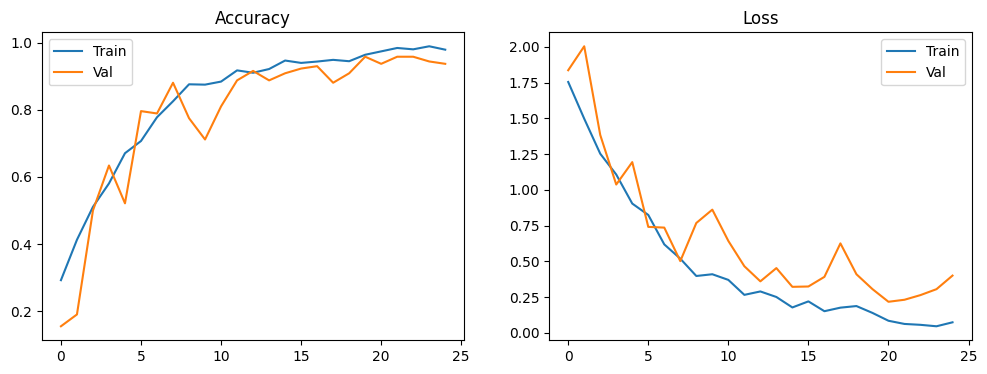

In [24]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Loss")
plt.legend()

plt.show()


In [27]:
# -------------------------------
# LOAD MODEL PROPERLY
# -------------------------------
checkpoint = torch.load("best_model.pth", map_location=DEVICE)

model.load_state_dict(checkpoint["model_state_dict"])
class_names = checkpoint["class_names"]

model.to(DEVICE)
model.eval()

# -------------------------------
# EVALUATION
# -------------------------------
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        outputs = model(x)
        preds = outputs.argmax(dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [28]:
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    zero_division=0
))


                 precision    recall  f1-score   support

   Missing_hole       1.00      0.97      0.98        63
     Mouse_bite       0.91      1.00      0.95        50
   Open_circuit       0.94      0.98      0.96        45
          Short       0.98      0.96      0.97        53
           Spur       0.94      0.86      0.90        36
Spurious_copper       1.00      0.97      0.99        36

       accuracy                           0.96       283
      macro avg       0.96      0.96      0.96       283
   weighted avg       0.96      0.96      0.96       283



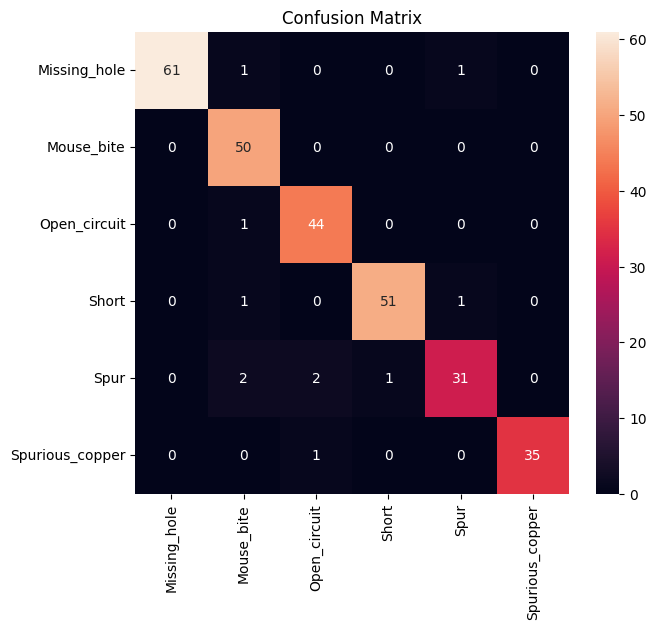

In [29]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()
